In [1]:
import numpy as np
import pandas as pd 
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle, randint
from numpy import mean, std, dstack
from pandas import read_csv


from keras import backend as K
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model, Sequential
from keras.layers import (Input, Dense, Flatten, Dropout, Conv1D, LSTM, GRU,
                          TimeDistributed, GlobalAveragePooling1D, MaxPooling1D)
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam, RMSprop,SGD
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from scipy import signal

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
with pd.option_context("display.max_rows", 10, "display.max_columns", 20):
    print(pd.get_option("display.max_rows")) 
    print(pd.get_option("display.max_columns"))
    

Using TensorFlow backend.
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorflow/python

10
20


/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jurgen/.local/lib/python3.6/site-packages/tensorboard/compat/ten

In [2]:
cd ..

/home/jurgen/PycharmProjects/SygnalAnalysis


# Declare common display graphics functions

In [3]:
def display_block_of_values(dataframe=pd.DataFrame, x_label='x_label', y_label='y_label',figsize=(15,30), plot_size=(30,2)):
    assert isinstance(dataframe, pd.DataFrame)
    plt.figure(figsize=figsize)
    for index, col in enumerate(dataframe.columns):
        plt.subplot(plot_size[0],plot_size[1], index+1)
        plt.plot(dataframe[col])
        plt.title(col)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.tight_layout()
        
        
def display_distribution_graphic(data_frame, suptitle='key'):
    plt.figure(figsize=(15,15))
    plt.suptitle(suptitle, fontsize=16)
    for ind, col in enumerate(data_frame.columns):
        plt.subplot(5,5, ind+1)
        plt.hist(data_frame[col])
        plt.title(col)
        plt.xlabel("Amplitude")
        plt.ylabel("Counts")
        plt.tight_layout()
        

In [4]:
from core.controller import GasolineSignalController
signals = GasolineSignalController(filepath="/media/jurgen/Новый том/Sygnaldatasets/kaspersky/GHL/01_Lev_fault_Temp_corr_seed_11_vars_23.csv", 
                           encoding="cp1251", delimiter=",",corr_threshold=0.9)

Number of columns: 23
Read Gasoline
Number of columns after clean: 22
Number of columns after corr analysis: 17
savgol filter smoothing successful
successfully scaled control_results
successfully scaled savgol filter control results


In [5]:
signals.control_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204560 entries, 0 to 204559
Data columns (total 17 columns):
RT_level_ini        204560 non-null float64
DANGER              204560 non-null float64
FAULT               204560 non-null float64
RT_temperature.T    204560 non-null float64
C_temperature.T     204560 non-null float64
RT_level            204560 non-null float64
out_valve_act       204560 non-null float64
dT_rand             204560 non-null float64
inv_valve_act       204560 non-null float64
inj_valve_act       204560 non-null float64
Relaxing.active     204560 non-null float64
dir_valve_act       204560 non-null float64
dt_rand             204560 non-null float64
C_level             204560 non-null float64
HT_temperature.T    204560 non-null float64
heater_act          204560 non-null float64
ATTACK              204560 non-null float64
dtypes: float64(17)
memory usage: 26.5 MB


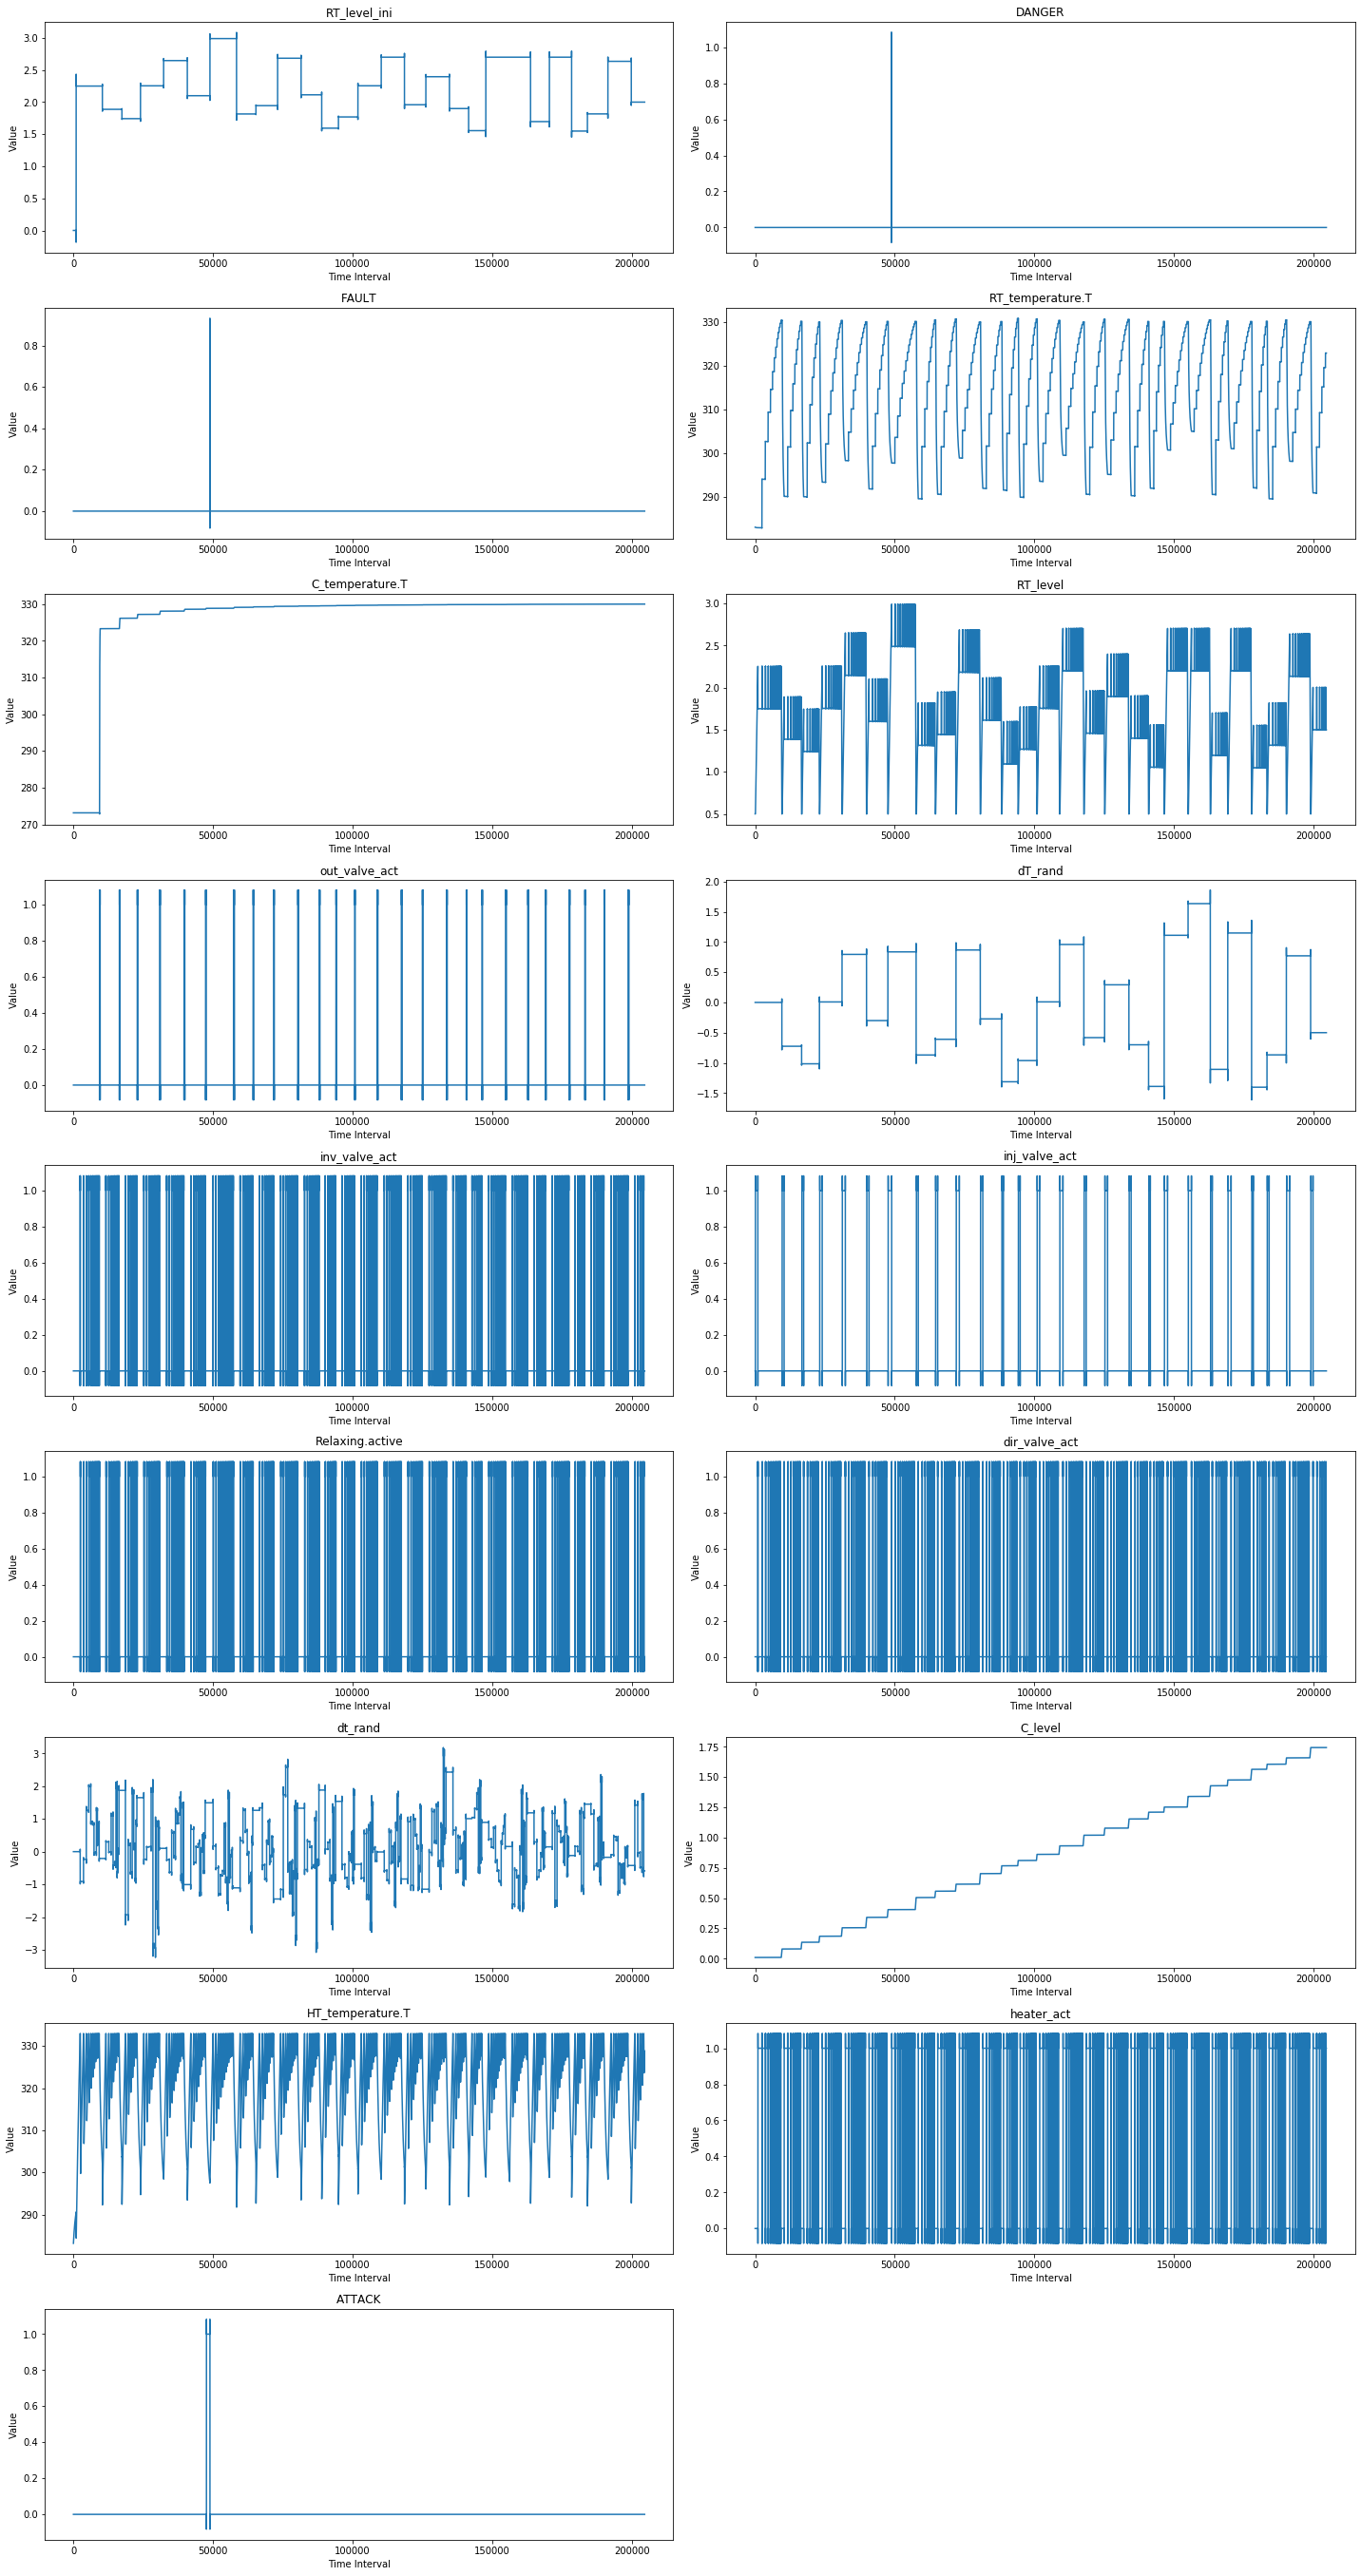

In [6]:
display_block_of_values(signals.savgol_filter_smoothing,
              x_label='Time Interval',
              y_label='Value', 
              figsize=(20, 100),
              plot_size=(24,2))

План работы с GHL dataset - 
- Загрузить все образцы из хранилища c помощью SignalController 
- Разделить каждый образец на 4, 8, 16 (выбрать) подобразцом с наличием и аномальных и безаномальных участков 
- Разделить целевой и информативный признаки 
- Произвести корреляционную проверку, стандартизирование, сглаживание 
- Подготовить конфигурацию нейронной сети под признаковое пространство 
- Подготовить набор данных для обучения и тестирования алгоритма 
- Обучить модель 

In [7]:
signals.control_results['DANGER'] = signals.control_results['DANGER'].astype('category')
signals.control_results['FAULT'] = signals.control_results['FAULT'].astype('category')
signals.control_results['ATTACK'] = signals.control_results['ATTACK'].astype('category')
print(signals.control_results['ATTACK'].value_counts())
print(signals.control_results['FAULT'].value_counts())
print(signals.control_results['DANGER'].value_counts())

0.0    203306
1.0      1254
Name: ATTACK, dtype: int64
0.0    204553
1.0         7
Name: FAULT, dtype: int64
0.0    204412
1.0       148
Name: DANGER, dtype: int64


# Have a look at PCA 

In [8]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(signals.control_results.drop(['ATTACK', 'DANGER', 'FAULT'],  axis=1))

signals.control_results['pca-one'] = pca_result[:,0]
signals.control_results['pca-two'] = pca_result[:,1] 
signals.control_results['pca-three'] = pca_result[:,2]

Объясненная вариация по основному компоненту: [0.54710933 0.32581321 0.12013949]


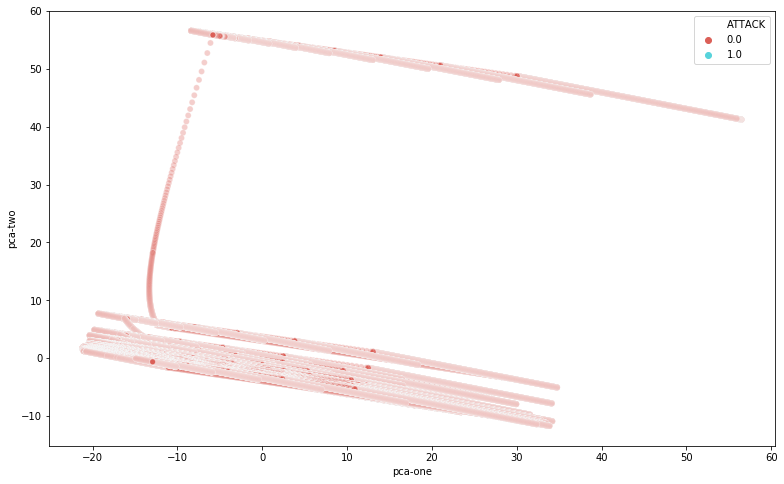

In [9]:
print('Объясненная вариация по основному компоненту: {}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(13,8))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 2),
    data=signals.control_results,
    hue="ATTACK",
    legend="full",
    alpha=0.3
)

ValueError: Colormap  is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

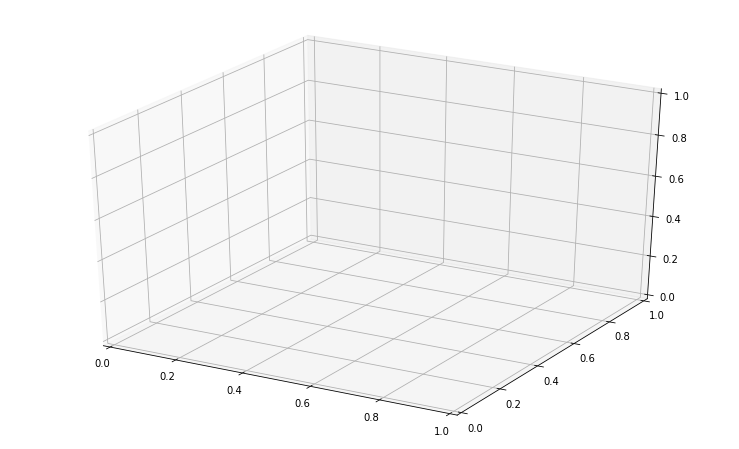

In [12]:
ax = plt.figure(figsize=(13,8)).gca(projection='3d')
ax.scatter(
    xs=signals.control_results["pca-one"], 
    ys=signals.control_results["pca-two"], 
    zs=signals.control_results["pca-three"], 
    c=signals.control_results['ATTACK'].cat.codes.values,
    cmap=''
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [11]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(signals.control_results.drop(['ATTACK', 'DANGER', 'FAULT'], axis=1))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 204560 samples in 3.478s...
[t-SNE] Computed neighbors for 204560 samples in 10.819s...
[t-SNE] Computed conditional probabilities for sample 1000 / 204560
[t-SNE] Computed conditional probabilities for sample 2000 / 204560
[t-SNE] Computed conditional probabilities for sample 3000 / 204560
[t-SNE] Computed conditional probabilities for sample 4000 / 204560
[t-SNE] Computed conditional probabilities for sample 5000 / 204560
[t-SNE] Computed conditional probabilities for sample 6000 / 204560
[t-SNE] Computed conditional probabilities for sample 7000 / 204560
[t-SNE] Computed conditional probabilities for sample 8000 / 204560
[t-SNE] Computed conditional probabilities for sample 9000 / 204560
[t-SNE] Computed conditional probabilities for sample 10000 / 204560
[t-SNE] Computed conditional probabilities for sample 11000 / 204560
[t-SNE] Computed conditional probabilities for sample 12000 / 204560
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 118000 / 204560
[t-SNE] Computed conditional probabilities for sample 119000 / 204560
[t-SNE] Computed conditional probabilities for sample 120000 / 204560
[t-SNE] Computed conditional probabilities for sample 121000 / 204560
[t-SNE] Computed conditional probabilities for sample 122000 / 204560
[t-SNE] Computed conditional probabilities for sample 123000 / 204560
[t-SNE] Computed conditional probabilities for sample 124000 / 204560
[t-SNE] Computed conditional probabilities for sample 125000 / 204560
[t-SNE] Computed conditional probabilities for sample 126000 / 204560
[t-SNE] Computed conditional probabilities for sample 127000 / 204560
[t-SNE] Computed conditional probabilities for sample 128000 / 204560
[t-SNE] Computed conditional probabilities for sample 129000 / 204560
[t-SNE] Computed conditional probabilities for sample 130000 / 204560
[t-SNE] Computed conditional probabilities for sample 131000 / 204560
[t-SNE] Computed con

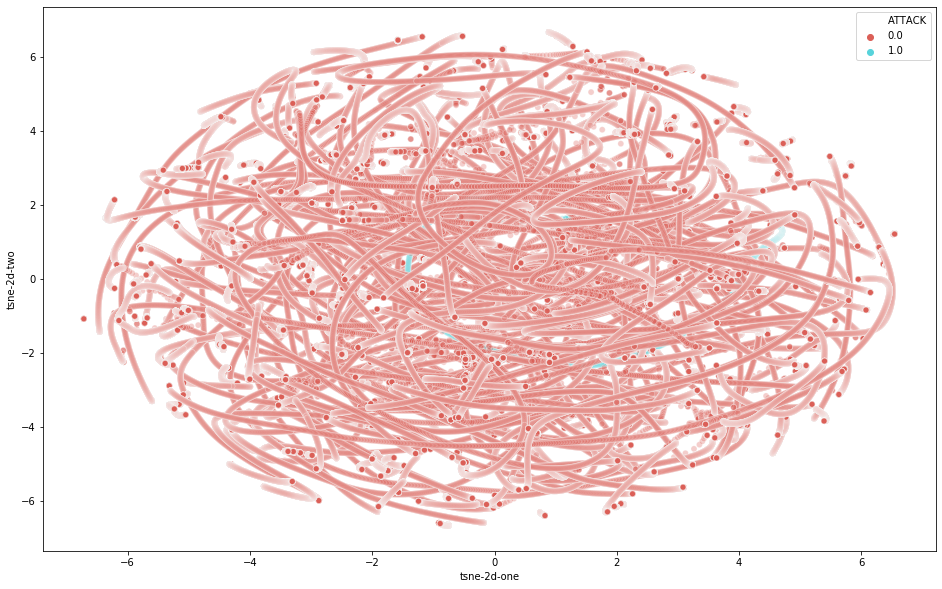

In [12]:
signals.control_results['tsne-2d-one'] = tsne_results[:,0]
signals.control_results['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="ATTACK",
    palette=sns.color_palette("hls", 2),
    data=signals.control_results,
    legend="full",
    alpha=0.3
)

In [ ]:
В данном примере имеем сгенерированные аномалии с первой степенью иннерционности (различная длинна), для одного сигнала.

# Convolutional Neural Network with categorical class definition

In [ ]:
X_data = noise_generator.anomaly_signal_samples + noise_generator.signal_samples
shuffle(X_data)

X = np.array([signal.values for signal in X_data])
# Y = np.array([signal.condition_window for signal in X_data])
Y = np.array([int(signal.abnormal) for signal in X_data])

print(X.shape)
print(Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(
     X, Y, test_size=0.33, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
Y_train = Y_train.reshape((Y_train.shape[0], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# trainY = Y
print(X_train.shape)
print(Y_train.shape)

# trainY = Y
print(X_test.shape)
print(Y_test.shape)

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 50, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=1)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=1)
    return accuracy



In [ ]:
# run an experiment
def run_experiment(repeats=1):
    # load data
#     trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
#         score = evaluate_model(trainX, trainy, testX, testy)
        score = evaluate_model(X_train, Y_train, X_test, Y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()